## Engenharia e Seleção de Atributos

Nesta etapa, o objetivo é transformar os dados brutos do processo de
flotação em um conjunto de atributos coerente com:

- a escala temporal real de aferição do target;
- a dinâmica física e operacional do processo;
- as conclusões obtidas na análise exploratória.

O foco não está em maximizar desempenho preditivo, mas em construir
representações interpretáveis, temporalmente consistentes e alinhadas
com o uso futuro dos modelos.

In [ ]:
import sys
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Garante que a raiz do projeto esteja no PYTHONPATH
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

from src.paths import *
from src.config import *
from src.io import *

create_project_structure()
set_global_seed()

# Dataset condicionado (sem duplicatas, com data corrigida)

In [4]:
data_path = PROCESSED_DATA_DIR / "mining_process_conditioned.parquet"
df = load_data(data_path)

df.shape

(736282, 26)

# Premissas Temporais

As variáveis de qualidade (% Iron Concentrate e % Silica Concentrate)
são aferidas em laboratório com periodicidade horária e registradas no
sistema no momento em que o resultado fica disponível.

Assim, o timestamp do target representa o instante de conhecimento da
qualidade, e não o momento exato de coleta da amostra.

Dessa forma:
- o target em T deve ser explicado apenas por variáveis de processo
  anteriores a T;
- todas as variáveis explicativas são temporalmente defasadas;
- evita-se qualquer forma de vazamento temporal.

# Definição do Target

O target do problema é a qualidade do concentrado, representada por:

- % Iron Concentrate
- % Silica Concentrate

Essas variáveis serão tratadas em escala horária, respeitando a forma
real de medição e evitando persistência artificial de valores.

In [6]:
target_cols = ["% Iron Concentrate", "% Silica Concentrate"]

df_target_hourly = (
    df
    .set_index("date_corrigida")
    .groupby(pd.Grouper(freq="1h"))[target_cols]
    .first()
    .dropna()
)

df_target_hourly.head()

,% Iron Concentrate,% Silica Concentrate
date_corrigida,,
2017-03-10 01:00:00,66.91,1.31
2017-03-10 02:00:00,67.06,1.11
2017-03-10 03:00:00,66.97,1.27
2017-03-10 04:00:00,66.75,1.36
2017-03-10 05:00:00,66.63,1.34


# Variáveis de Processo

As variáveis de processo incluem:

- características da alimentação;
- vazões de reagentes;
- variáveis de estado do processo.

Essas variáveis são medidas em alta frequência e precisam ser agregadas
temporalmente para alinhar-se ao target horário.


In [ ]:
# Consolidação horária das variáveis de processo 
# (agregação pela média, lembrando que o objetivo aqui é revelar o potencial preditivo dos dados,\
# outras estatísticas poderiam ser usadas, bem como detecção de drift e refinamento mais aprofundado dos dados)
process_cols = [
    col for col in df.columns
    if col not in target_cols + ["date", "date_corrigida", "original_order"]
]

df_process_hourly = (
    df
    .set_index("date_corrigida")[process_cols]
    .groupby(pd.Grouper(freq="1H"))
    .agg(["mean", "std"])
)

# achatamento multi-indexado
df_process_hourly.columns = [
    f"{var}_{stat}" for var, stat in df_process_hourly.columns
]

df_process_hourly.head()

C:\Users\gabri\AppData\Local\Temp\ipykernel_22980\1436068548.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(freq="1H"))


,% Iron Feed_mean,% Iron Feed_std,% Silica Feed_mean,% Silica Feed_std,Starch Flow_mean,Starch Flow_std,Amina Flow_mean,Amina Flow_std,Ore Pulp Flow_mean,Ore Pulp Flow_std,...,Flotation Column 03 Level_mean,Flotation Column 03 Level_std,Flotation Column 04 Level_mean,Flotation Column 04 Level_std,Flotation Column 05 Level_mean,Flotation Column 05 Level_std,Flotation Column 06 Level_mean,Flotation Column 06 Level_std,Flotation Column 07 Level_mean,Flotation Column 07 Level_std
date_corrigida,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,0.0,16.98,0.0,3162.625026,550.741660,578.786678,19.985162,398.753368,4.742481,...,450.474523,11.917634,449.912259,27.385709,455.792161,28.046224,464.383310,30.091768,450.532747,42.397221
2017-03-10 02:00:00,55.2,0.0,16.98,0.0,3133.256389,511.766781,537.219661,21.517606,399.871822,4.100871,...,450.081222,7.568587,450.328806,19.554887,448.722983,31.191553,455.501528,19.413047,451.387700,35.961193
2017-03-10 03:00:00,55.2,0.0,16.98,0.0,3479.482944,154.079107,591.906744,8.795228,398.763806,4.176518,...,450.901822,10.279704,451.145822,21.160415,451.134189,31.249577,459.981311,24.794114,450.296722,37.799090
2017-03-10 04:00:00,55.2,0.0,16.98,0.0,3228.036436,445.121305,593.170106,12.798436,399.866983,4.603402,...,487.387206,51.789664,494.528183,57.751457,495.664011,66.828362,502.763850,55.535295,494.939889,64.871153
2017-03-10 05:00:00,55.2,0.0,16.98,0.0,3327.280739,554.332822,619.710806,7.853232,399.615089,4.204111,...,549.459572,10.221195,549.975483,13.131438,549.512533,9.686328,560.696300,28.174452,550.271772,28.349167


In [26]:
# Alinhamento processo → target
df_model = (
    df_target_hourly
    .join(df_process_hourly, how="inner")
    .sort_index()
)

df_model.shape

(4097, 44)

In [27]:
df_model

,% Iron Concentrate,% Silica Concentrate,% Iron Feed_mean,% Iron Feed_std,% Silica Feed_mean,% Silica Feed_std,Starch Flow_mean,Starch Flow_std,Amina Flow_mean,Amina Flow_std,...,Flotation Column 03 Level_mean,Flotation Column 03 Level_std,Flotation Column 04 Level_mean,Flotation Column 04 Level_std,Flotation Column 05 Level_mean,Flotation Column 05 Level_std,Flotation Column 06 Level_mean,Flotation Column 06 Level_std,Flotation Column 07 Level_mean,Flotation Column 07 Level_std
date_corrigida,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,66.91,1.31,55.20,0.0,16.98,0.0,3162.625026,550.741660,578.786678,19.985162,...,450.474523,11.917634,449.912259,27.385709,455.792161,28.046224,464.383310,30.091768,450.532747,42.397221
2017-03-10 02:00:00,67.06,1.11,55.20,0.0,16.98,0.0,3133.256389,511.766781,537.219661,21.517606,...,450.081222,7.568587,450.328806,19.554887,448.722983,31.191553,455.501528,19.413047,451.387700,35.961193
2017-03-10 03:00:00,66.97,1.27,55.20,0.0,16.98,0.0,3479.482944,154.079107,591.906744,8.795228,...,450.901822,10.279704,451.145822,21.160415,451.134189,31.249577,459.981311,24.794114,450.296722,37.799090
2017-03-10 04:00:00,66.75,1.36,55.20,0.0,16.98,0.0,3228.036436,445.121305,593.170106,12.798436,...,487.387206,51.789664,494.528183,57.751457,495.664011,66.828362,502.763850,55.535295,494.939889,64.871153
2017-03-10 05:00:00,66.63,1.34,55.20,0.0,16.98,0.0,3327.280739,554.332822,619.710806,7.853232,...,549.459572,10.221195,549.975483,13.131438,549.512533,9.686328,560.696300,28.174452,550.271772,28.349167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,65.05,1.65,49.75,0.0,23.20,0.0,3327.047776,697.144472,497.211189,9.879915,...,403.858956,55.035778,398.930467,31.808504,502.971728,83.740371,399.468911,64.330518,400.559511,48.397111
2017-09-09 20:00:00,64.83,1.71,49.75,0.0,23.20,0.0,4225.800333,318.440036,508.963856,16.141752,...,399.208611,50.226106,399.967122,26.046485,501.624533,71.639020,398.905006,42.086400,400.486233,36.893656
2017-09-09 21:00:00,64.29,1.80,49.75,0.0,23.20,0.0,2808.214692,748.316919,517.748822,9.303296,...,471.827489,116.833397,399.931033,29.102674,500.223311,79.523248,401.899806,58.479646,400.556333,70.797409


# Defasagem Temporal

Com base na análise de autocorrelação e no entendimento do processo,
assume-se que a qualidade em T depende do estado do processo em horas
anteriores.

Nesta etapa, são construídas defasagens horárias das variáveis de
processo, respeitando a causalidade temporal.

In [28]:
LAGS = [1, 2, 3]  # horas anteriores

lagged_features = []

for lag in LAGS:
    lagged = df_process_hourly.shift(lag)
    lagged.columns = [f"{c}_lag{lag}h" for c in lagged.columns]
    lagged_features.append(lagged)

df_lagged = pd.concat(lagged_features, axis=1)

df_model_lagged = (
    df_target_hourly
    .join(df_lagged, how="inner")
    .dropna()
)

df_model_lagged.shape

(4083, 128)

In [29]:
df_model_lagged

,% Iron Concentrate,% Silica Concentrate,% Iron Feed_mean_lag1h,% Iron Feed_std_lag1h,% Silica Feed_mean_lag1h,% Silica Feed_std_lag1h,Starch Flow_mean_lag1h,Starch Flow_std_lag1h,Amina Flow_mean_lag1h,Amina Flow_std_lag1h,...,Flotation Column 03 Level_mean_lag3h,Flotation Column 03 Level_std_lag3h,Flotation Column 04 Level_mean_lag3h,Flotation Column 04 Level_std_lag3h,Flotation Column 05 Level_mean_lag3h,Flotation Column 05 Level_std_lag3h,Flotation Column 06 Level_mean_lag3h,Flotation Column 06 Level_std_lag3h,Flotation Column 07 Level_mean_lag3h,Flotation Column 07 Level_std_lag3h
date_corrigida,,,,,,,,,,,,,,,,,,,,,
2017-03-10 04:00:00,66.75,1.36,55.20,0.0,16.98,0.0,3479.482944,154.079107,591.906744,8.795228,...,450.474523,11.917634,449.912259,27.385709,455.792161,28.046224,464.383310,30.091768,450.532747,42.397221
2017-03-10 05:00:00,66.63,1.34,55.20,0.0,16.98,0.0,3228.036436,445.121305,593.170106,12.798436,...,450.081222,7.568587,450.328806,19.554887,448.722983,31.191553,455.501528,19.413047,451.387700,35.961193
2017-03-10 06:00:00,66.85,1.15,55.20,0.0,16.98,0.0,3327.280739,554.332822,619.710806,7.853232,...,450.901822,10.279704,451.145822,21.160415,451.134189,31.249577,459.981311,24.794114,450.296722,37.799090
2017-03-10 07:00:00,65.76,2.76,55.20,0.0,16.98,0.0,3405.162222,129.738782,621.878539,7.483721,...,487.387206,51.789664,494.528183,57.751457,495.664011,66.828362,502.763850,55.535295,494.939889,64.871153
2017-03-10 08:00:00,65.89,2.65,54.95,0.0,17.40,0.0,2865.878428,869.818348,618.186367,6.178224,...,549.459572,10.221195,549.975483,13.131438,549.512533,9.686328,560.696300,28.174452,550.271772,28.349167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,65.05,1.65,49.75,0.0,23.20,0.0,2582.123305,724.676820,489.346178,11.145650,...,400.261983,11.207898,403.316350,70.294243,433.943950,70.618082,399.976206,26.615120,399.181494,21.194874
2017-09-09 20:00:00,64.83,1.71,49.75,0.0,23.20,0.0,3327.047776,697.144472,497.211189,9.879915,...,400.018839,10.596405,400.276194,21.638575,498.182283,67.419528,398.953489,51.283731,401.583039,31.250676
2017-09-09 21:00:00,64.29,1.80,49.75,0.0,23.20,0.0,4225.800333,318.440036,508.963856,16.141752,...,415.447022,87.756662,405.179539,92.295144,499.766694,95.834350,406.676483,63.733089,402.949094,85.461825


## Considerações sobre Dimensionalidade

A engenharia de atributos resulta em um número elevado de variáveis,
muitas delas potencialmente correlacionadas.

Neste estágio, opta-se por:
- manter redundâncias controladas;
- priorizar interpretabilidade;
- postergar reduções agressivas para etapas posteriores.

Essa decisão permite avaliar o comportamento dos modelos de forma mais
transparente.

# Análise de correlação entre features

In [ ]:
# Matriz de correlação apenas entre features explicativas
X_features = df_model_lagged.drop(columns=target_cols)
corr_matrix = X_features.corr().abs()
corr_matrix.shape

(126, 126)

* Onde estão as correlações altas?

In [55]:
corr = X_features.corr()

corr_pairs = (
    corr
    .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ["feature_1", "feature_2", "correlation"]
corr_pairs["abs_corr"] = corr_pairs["correlation"].abs()
corr_pairs[corr_pairs.abs_corr >=.8].sort_values("abs_corr", ascending=False)

,feature_1,feature_2,correlation,abs_corr
5288,Flotation Column 04 Air Flow_mean_lag2h,Flotation Column 04 Air Flow_mean_lag3h,0.992285,0.992285
2028,Flotation Column 04 Air Flow_mean_lag1h,Flotation Column 04 Air Flow_mean_lag2h,0.992278,0.992278
5409,Flotation Column 05 Air Flow_mean_lag2h,Flotation Column 05 Air Flow_mean_lag3h,0.982326,0.982326
2229,Flotation Column 05 Air Flow_mean_lag1h,Flotation Column 05 Air Flow_mean_lag2h,0.982306,0.982306
2068,Flotation Column 04 Air Flow_mean_lag1h,Flotation Column 04 Air Flow_mean_lag3h,0.981702,0.981702
...,...,...,...,...
1652,Flotation Column 02 Air Flow_mean_lag1h,Flotation Column 01 Air Flow_mean_lag3h,0.814144,0.814144
6148,Flotation Column 05 Level_mean_lag2h,Flotation Column 07 Level_mean_lag3h,0.808520,0.808520
3528,Flotation Column 05 Level_mean_lag1h,Flotation Column 07 Level_mean_lag2h,0.808397,0.808397
6314,Flotation Column 07 Level_mean_lag2h,Flotation Column 05 Level_mean_lag3h,0.801819,0.801819


Correlação elevada entre atributos indica de informaçao. Em processos industriais,\
esse fenômeno é esperado, especialmente entre sensores que monitoram partes próximas\
do sistema ou variáveis derivadas de agregações semelhantes.

In [ ]:
"""
0,7 ~ 0,8 → correlação forte, mas muitas vezes aceitável
0,9 → alta correlação, possível redundância
0,95+ → redundância quase certa
"""
threshold = 0.95

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > threshold)
]

len(to_drop)

20

In [33]:
to_drop

['% Silica Feed_mean_lag1h',
 'Flotation Column 03 Air Flow_mean_lag1h',
 '% Iron Feed_mean_lag2h',
 '% Silica Feed_mean_lag2h',
 'Flotation Column 01 Air Flow_mean_lag2h',
 'Flotation Column 02 Air Flow_mean_lag2h',
 'Flotation Column 03 Air Flow_mean_lag2h',
 'Flotation Column 04 Air Flow_mean_lag2h',
 'Flotation Column 05 Air Flow_mean_lag2h',
 'Flotation Column 06 Air Flow_mean_lag2h',
 'Flotation Column 07 Air Flow_mean_lag2h',
 '% Iron Feed_mean_lag3h',
 '% Silica Feed_mean_lag3h',
 'Flotation Column 01 Air Flow_mean_lag3h',
 'Flotation Column 02 Air Flow_mean_lag3h',
 'Flotation Column 03 Air Flow_mean_lag3h',
 'Flotation Column 04 Air Flow_mean_lag3h',
 'Flotation Column 05 Air Flow_mean_lag3h',
 'Flotation Column 06 Air Flow_mean_lag3h',
 'Flotation Column 07 Air Flow_mean_lag3h']

In [34]:
X_reduced = X_features.drop(columns=to_drop)
X_reduced.shape

(4083, 106)

A remoção de atributos altamente correlacionados visa:

- reduzir multicolinearidade;
- facilitar interpretação posterior dos modelos;
- evitar instabilidade numérica em modelos lineares;
- manter um conjunto de atributos mais parcimonioso.

A escolha do limiar de correlação foi deliberadamente conservadora,
preservando a maior parte da informação original e evitando perdas
agressivas nesta etapa exploratória.

In [90]:
X_reduced.head()

,% Iron Feed_mean_lag1h,% Iron Feed_std_lag1h,% Silica Feed_std_lag1h,Starch Flow_mean_lag1h,Starch Flow_std_lag1h,Amina Flow_mean_lag1h,Amina Flow_std_lag1h,Ore Pulp Flow_mean_lag1h,Ore Pulp Flow_std_lag1h,Ore Pulp pH_mean_lag1h,...,Flotation Column 03 Level_mean_lag3h,Flotation Column 03 Level_std_lag3h,Flotation Column 04 Level_mean_lag3h,Flotation Column 04 Level_std_lag3h,Flotation Column 05 Level_mean_lag3h,Flotation Column 05 Level_std_lag3h,Flotation Column 06 Level_mean_lag3h,Flotation Column 06 Level_std_lag3h,Flotation Column 07 Level_mean_lag3h,Flotation Column 07 Level_std_lag3h
date_corrigida,,,,,,,,,,,,,,,,,,,,,
2017-03-10 04:00:00,55.20,0.0,0.0,3479.482944,154.079107,591.906744,8.795228,398.763806,4.176518,10.048403,...,450.474523,11.917634,449.912259,27.385709,455.792161,28.046224,464.383310,30.091768,450.532747,42.397221
2017-03-10 05:00:00,55.20,0.0,0.0,3228.036436,445.121305,593.170106,12.798436,399.866983,4.603402,9.918614,...,450.081222,7.568587,450.328806,19.554887,448.722983,31.191553,455.501528,19.413047,451.387700,35.961193
2017-03-10 06:00:00,55.20,0.0,0.0,3327.280739,554.332822,619.710806,7.853232,399.615089,4.204111,9.746029,...,450.901822,10.279704,451.145822,21.160415,451.134189,31.249577,459.981311,24.794114,450.296722,37.799090
2017-03-10 07:00:00,55.20,0.0,0.0,3405.162222,129.738782,621.878539,7.483721,399.749344,3.799719,9.892237,...,487.387206,51.789664,494.528183,57.751457,495.664011,66.828362,502.763850,55.535295,494.939889,64.871153
2017-03-10 08:00:00,54.95,0.0,0.0,2865.878428,869.818348,618.186367,6.178224,400.345133,3.679244,10.180426,...,549.459572,10.221195,549.975483,13.131438,549.512533,9.686328,560.696300,28.174452,550.271772,28.349167


# VIF (Variance Inflation Factor)

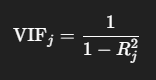

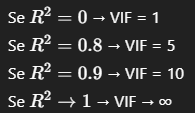

In [ ]:
# o quanto uma variável pode ser explicada pelas outras variáveis do conjunto?
# avalia multicolinearidade
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [ variance_inflation_factor(df.values, i) for i in range(df.shape[1]) ]
    return vif_data.sort_values("VIF", ascending=False)

In [66]:
vif_df = compute_vif(X_reduced)

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [94]:
vif_alto = vif_df[vif_df.VIF >= 10]

In [95]:
vif_alto

,feature,VIF
46,Ore Pulp Flow_mean_lag2h,13732.151986
18,Flotation Column 04 Air Flow_mean_lag1h,9784.855693
79,Ore Pulp Flow_mean_lag3h,8637.713312
7,Ore Pulp Flow_mean_lag1h,8584.260407
20,Flotation Column 05 Air Flow_mean_lag1h,8490.767525
50,Ore Pulp Density_mean_lag2h,5879.109666
48,Ore Pulp pH_mean_lag2h,5002.150822
11,Ore Pulp Density_mean_lag1h,3795.518683
83,Ore Pulp Density_mean_lag3h,3698.021451
9,Ore Pulp pH_mean_lag1h,3008.950522


* Essas variáveis carregam praticamente a mesma informação, deslocada no tempo ou agregada de forma semelhante (são deslocamentos do mesmo atributo no tempo, então não devem ser excluídas).

A análise de VIF indica forte multicolinearidade entre atributos derivados de uma mesma variável física e defasagens temporais consecutivas.\
Esse comportamento é esperado em dados industriais com forte dependência temporal e reflete a inércia do processo. O VIF é utilizado como\
ferramenta diagnóstica para identificar grupos redundantes de atributos, e não como critério automático de exclusão.

# Agrupamento conceitual das features

Após a redução inicial, os atributos podem ser organizados em grupos
conceituais, de acordo com seu papel no processo:

- **Alimentação**: características do minério e do material de entrada;
- **Reagentes**: variáveis de controle ativo do processo;
- **Estado do Processo**: variáveis com maior inércia física;
- **Condições Operacionais**: vazões de ar e níveis das colunas;
- **Histórico Temporal**: defasagens e agregações horárias.

Esse agrupamento auxilia tanto na interpretação quanto na avaliação
posterior dos modelos.

In [98]:
df_features_final = (
    df_target_hourly
    .join(X_reduced, how="inner")
    .dropna()
)

df_features_final.shape

(4083, 108)

In [99]:
df_features_final

,% Iron Concentrate,% Silica Concentrate,% Iron Feed_mean_lag1h,% Iron Feed_std_lag1h,% Silica Feed_std_lag1h,Starch Flow_mean_lag1h,Starch Flow_std_lag1h,Amina Flow_mean_lag1h,Amina Flow_std_lag1h,Ore Pulp Flow_mean_lag1h,...,Flotation Column 03 Level_mean_lag3h,Flotation Column 03 Level_std_lag3h,Flotation Column 04 Level_mean_lag3h,Flotation Column 04 Level_std_lag3h,Flotation Column 05 Level_mean_lag3h,Flotation Column 05 Level_std_lag3h,Flotation Column 06 Level_mean_lag3h,Flotation Column 06 Level_std_lag3h,Flotation Column 07 Level_mean_lag3h,Flotation Column 07 Level_std_lag3h
date_corrigida,,,,,,,,,,,,,,,,,,,,,
2017-03-10 04:00:00,66.75,1.36,55.20,0.0,0.0,3479.482944,154.079107,591.906744,8.795228,398.763806,...,450.474523,11.917634,449.912259,27.385709,455.792161,28.046224,464.383310,30.091768,450.532747,42.397221
2017-03-10 05:00:00,66.63,1.34,55.20,0.0,0.0,3228.036436,445.121305,593.170106,12.798436,399.866983,...,450.081222,7.568587,450.328806,19.554887,448.722983,31.191553,455.501528,19.413047,451.387700,35.961193
2017-03-10 06:00:00,66.85,1.15,55.20,0.0,0.0,3327.280739,554.332822,619.710806,7.853232,399.615089,...,450.901822,10.279704,451.145822,21.160415,451.134189,31.249577,459.981311,24.794114,450.296722,37.799090
2017-03-10 07:00:00,65.76,2.76,55.20,0.0,0.0,3405.162222,129.738782,621.878539,7.483721,399.749344,...,487.387206,51.789664,494.528183,57.751457,495.664011,66.828362,502.763850,55.535295,494.939889,64.871153
2017-03-10 08:00:00,65.89,2.65,54.95,0.0,0.0,2865.878428,869.818348,618.186367,6.178224,400.345133,...,549.459572,10.221195,549.975483,13.131438,549.512533,9.686328,560.696300,28.174452,550.271772,28.349167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,65.05,1.65,49.75,0.0,0.0,2582.123305,724.676820,489.346178,11.145650,380.557833,...,400.261983,11.207898,403.316350,70.294243,433.943950,70.618082,399.976206,26.615120,399.181494,21.194874
2017-09-09 20:00:00,64.83,1.71,49.75,0.0,0.0,3327.047776,697.144472,497.211189,9.879915,380.847200,...,400.018839,10.596405,400.276194,21.638575,498.182283,67.419528,398.953489,51.283731,401.583039,31.250676
2017-09-09 21:00:00,64.29,1.80,49.75,0.0,0.0,4225.800333,318.440036,508.963856,16.141752,381.112889,...,415.447022,87.756662,405.179539,92.295144,499.766694,95.834350,406.676483,63.733089,402.949094,85.461825


# Correlação com os targets

In [119]:
corr_targets = df_features_final.corr()[['% Iron Concentrate','% Silica Concentrate']]
corr_targets = np.abs(corr_targets)
corr_targets.sort_values(by='% Silica Concentrate', inplace=True, ascending=False)
corr_targets.dropna(inplace=True)
corr_targets[corr_targets['% Silica Concentrate'] >= 0.1]

,% Iron Concentrate,% Silica Concentrate
% Silica Concentrate,0.801750,1.000000
% Iron Concentrate,1.000000,0.801750
Flotation Column 01 Air Flow_mean_lag1h,0.108639,0.225408
Flotation Column 02 Air Flow_mean_lag1h,0.068831,0.174960
Flotation Column 05 Level_mean_lag1h,0.167246,0.173992
Ore Pulp pH_mean_lag3h,0.213894,0.163003
Flotation Column 05 Level_mean_lag2h,0.156363,0.160028
Ore Pulp pH_mean_lag2h,0.212108,0.159388
Flotation Column 04 Level_mean_lag1h,0.145892,0.159349
Flotation Column 04 Air Flow_std_lag2h,0.135512,0.157221


# Seleção do target

## Natureza do processo

* No processo de flotação o objetivo operacional principal é remover sílica;
* O teor de ferro no concentrado aumenta como consequência indireta;
* A sílica é a impureza de interesse.

Ou seja:
* O controle é exercido sobre a exclusão da sílica, não sobre o “ganho de ferro”.

## Redundância de informação entre os targets

As análises exploratórias mostraram que % Iron Concentrate e % Silica Concentrate:
* são fortemente correlacionados;
* exibem comportamento temporal complementar;
* refletem o mesmo compromisso metalúrgico.

Em termos práticos modelar ambos simultaneamente adiciona pouca informação nova.\
Escolher um evita a duplicação de esforço, modelos redundantes e conclusões repetidas.

## Por que não usar ferro como target principal?

Ele carrega informação já contida na sílica. Sua variação relativa é menor e ele\
é menos sensível a mudanças pontuais de processo.\
O ferro funciona melhor como indicador complementar, não como alvo primário.

In [102]:
df_features_target = df_features_final.drop(columns='% Iron Concentrate')
df_features_target.head()

,% Silica Concentrate,% Iron Feed_mean_lag1h,% Iron Feed_std_lag1h,% Silica Feed_std_lag1h,Starch Flow_mean_lag1h,Starch Flow_std_lag1h,Amina Flow_mean_lag1h,Amina Flow_std_lag1h,Ore Pulp Flow_mean_lag1h,Ore Pulp Flow_std_lag1h,...,Flotation Column 03 Level_mean_lag3h,Flotation Column 03 Level_std_lag3h,Flotation Column 04 Level_mean_lag3h,Flotation Column 04 Level_std_lag3h,Flotation Column 05 Level_mean_lag3h,Flotation Column 05 Level_std_lag3h,Flotation Column 06 Level_mean_lag3h,Flotation Column 06 Level_std_lag3h,Flotation Column 07 Level_mean_lag3h,Flotation Column 07 Level_std_lag3h
date_corrigida,,,,,,,,,,,,,,,,,,,,,
2017-03-10 04:00:00,1.36,55.20,0.0,0.0,3479.482944,154.079107,591.906744,8.795228,398.763806,4.176518,...,450.474523,11.917634,449.912259,27.385709,455.792161,28.046224,464.383310,30.091768,450.532747,42.397221
2017-03-10 05:00:00,1.34,55.20,0.0,0.0,3228.036436,445.121305,593.170106,12.798436,399.866983,4.603402,...,450.081222,7.568587,450.328806,19.554887,448.722983,31.191553,455.501528,19.413047,451.387700,35.961193
2017-03-10 06:00:00,1.15,55.20,0.0,0.0,3327.280739,554.332822,619.710806,7.853232,399.615089,4.204111,...,450.901822,10.279704,451.145822,21.160415,451.134189,31.249577,459.981311,24.794114,450.296722,37.799090
2017-03-10 07:00:00,2.76,55.20,0.0,0.0,3405.162222,129.738782,621.878539,7.483721,399.749344,3.799719,...,487.387206,51.789664,494.528183,57.751457,495.664011,66.828362,502.763850,55.535295,494.939889,64.871153
2017-03-10 08:00:00,2.65,54.95,0.0,0.0,2865.878428,869.818348,618.186367,6.178224,400.345133,3.679244,...,549.459572,10.221195,549.975483,13.131438,549.512533,9.686328,560.696300,28.174452,550.271772,28.349167


In [103]:
df_features_target.shape

(4083, 107)

# Backup dos dados

In [100]:
caminho_tratado = PROCESSED_DATA_DIR / "engineer_and_selection.parquet"
save_data(df_features_final, caminho_tratado)

Salvando: C:\jupyter notebooks\IHM\data\processed\engineer_and_selection.parquet (Compressão: Zstd)


In [105]:
caminho_target_si = PROCESSED_DATA_DIR / "data_for_modeling.parquet"
save_data(df_features_target, caminho_target_si)

Salvando: C:\jupyter notebooks\IHM\data\processed\data_for_modeling.parquet (Compressão: Zstd)
